#### Let's take a look at the data

In [1]:
import pandas as pd
import matplotlib.pyplot as pyplot

In [2]:
URM_all_dataframe = pd.read_csv('data_train.csv', 
                                sep=",", 
                                header= 0, 
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [3]:
URM_all_dataframe.head(n=100)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
...,...,...,...
95,4,47,1.0
96,4,70,1.0
97,4,79,1.0
98,4,119,1.0


In [4]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 478730


### Now we can extract the list of unique user id and item id and display some statistics

In [5]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

In [6]:
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024



### See that the max ID of items and users is higher than the number of unique values -> empty profiles
### We should remove empty indices, to do so we create a new mapping

In [7]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)
user_index_to_original_ID = pd.Series(original_id, index = mapped_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)
index_to_item_original = pd.Series(original_id, index = mapped_id)

### We now replace the IDs in the dataframe and we are ready to use the data

In [8]:
URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)


In [9]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [10]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))


Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [4]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values))) ## .values --> numpy array, df[..] --> pd series


In [5]:
URM_all.tocsr()

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

In [6]:
import numpy as np
print(URM_all.tocsc().indptr)
item_popularity = np.ediff1d(URM_all.tocsc().indptr) # differences between number of occurences of the column


[     0      0   1581 ... 478723 478728 478730]


In [7]:
item_popularity = np.sort(item_popularity)
item_popularity

array([   0,    0,    0, ..., 1581, 1666, 1764])

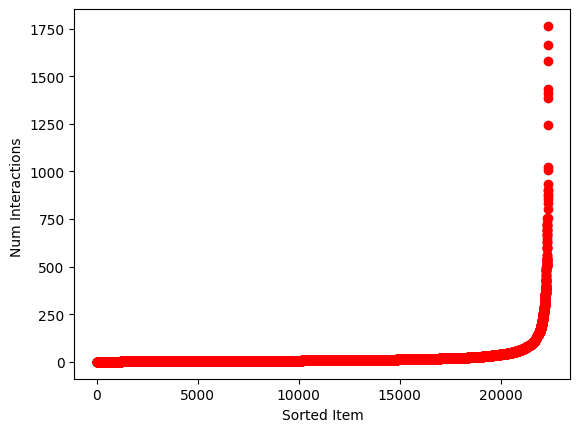

In [8]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [16]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 21.54
Average per-item interactions for the top 10% popular items 122.73
Average per-item interactions for the least 10% popular items 2.35
Average per-item interactions for the median 10% popular items 8.37


In [17]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

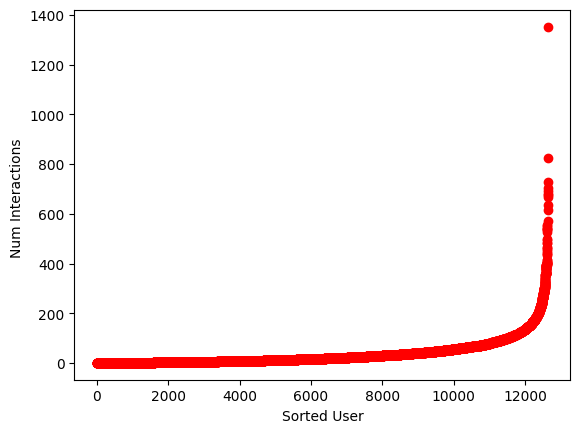

In [18]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A functon computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:
#### - Train data: we will use this to train our model
#### - Test data: we will use this to evaluate our model

In [19]:
train_test_split = 0.80

n_interactions = URM_all.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True, False, ...,  True,  True,  True])

In [20]:
URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

URM_train

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 383070 stored elements in Compressed Sparse Row format>

In [21]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))

URM_test

<13025x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 95660 stored elements in Compressed Sparse Row format>

### Evaluation metric

#### We call items in the test set 'relevant'

### Precision: how many of the recommended items are relevant

In [22]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

### Recall: how many of the relevant items I was able to recommend

In [23]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

### Average Precision

In [24]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

### Put all together in an evaluation function and let's test it!

In [25]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 


# Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### In this case our model is the item popularity

### Now train and test our model

In [26]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_train.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=10, remove_seen=True):

        if remove_seen:

            if(user_id == -1):
                recommended_items = self.popular_items[0:at]
            
            else:
                seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
                unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)

                unseen_items = self.popular_items[unseen_items_mask]

                recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
            

        return recommended_items


In [35]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(URM_all.tocsr())

In [36]:
topPopRecommender_removeSeen.recommend(9)

array([ 2,  4,  1,  7,  3,  6,  8,  9, 15, 20], dtype=int64)

In [31]:
evaluate_algorithm(URM_test, topPopRecommender_removeSeen, at = 10)

Recommender results are: Precision = 0.0289, Recall = 0.0461, MAP = 0.0214


In [32]:
topPopRecommender_removeSeen.recommend(10)

array([ 2,  4,  1,  6,  7,  3,  8,  9, 15, 20], dtype=int64)

In [96]:
prediction_df = pd.read_csv('data_target_users_test.csv', sep= ",",
                                header=0, 
                                dtype={0:int},
                                engine='python')
prediction_df.tail(10)


,user_id
10872,13010
10873,13012
10874,13013
10875,13015
10876,13019
10877,13020
10878,13021
10879,13022
10880,13023
10881,13024


In [117]:
def write_predictions(recommender_object,URM,user_original_ID_to_index, index_to_item_original,at=10):
    prediction_df = pd.read_csv('data_target_users_test.csv', sep= ",",
                                header=0, 
                                dtype={0:int},
                                engine='python')
    prediction_df['mapped user'] = prediction_df['user_id'].map(user_original_ID_to_index).fillna(-1).astype(int)
    prediction_df['item_list'] = prediction_df['mapped user'].apply(recommender_object.recommend)
    def map_items(item_list):
        return [index_to_item_original.get(item, item) for item in item_list]

    prediction_df['item_list'] = prediction_df['item_list'].apply(map_items)
    def transform_items_to_string(item_list):
        return ' '.join(map(str, item_list))

    prediction_df['item_list'] = prediction_df['item_list'].apply(transform_items_to_string)
    print(prediction_df.head(10))
    del prediction_df['mapped user']
    prediction_df.to_csv('submission.csv',index=False)

write_predictions(topPopRecommender_removeSeen,URM_all_dataframe,user_original_ID_to_index, index_to_item_original)

        

   user_id  mapped user                 item_list
0        1            0    2 4 1 6 3 8 9 15 20 14
1        2            1    2 4 7 6 3 8 9 15 20 14
2        3            2     2 4 1 7 6 3 8 9 15 20
3        4            3     2 4 1 7 6 3 8 9 15 20
4        5            4     2 4 1 7 6 3 8 9 15 20
5        6            5    2 4 7 6 3 8 9 15 20 14
6        8            7    2 4 7 6 3 8 9 15 20 14
7        9            8     2 4 1 7 6 3 8 9 15 20
8       10            9     2 4 1 7 6 3 8 9 15 20
9       11           10  2 4 7 6 9 15 20 14 11 10


In [118]:
prediction_df = pd.read_csv('submission.csv', sep= ",",
                                header=0, 
                                engine='python')
print(prediction_df.head(10))

   user_id                 item_list
0        1    2 4 1 6 3 8 9 15 20 14
1        2    2 4 7 6 3 8 9 15 20 14
2        3     2 4 1 7 6 3 8 9 15 20
3        4     2 4 1 7 6 3 8 9 15 20
4        5     2 4 1 7 6 3 8 9 15 20
5        6    2 4 7 6 3 8 9 15 20 14
6        8    2 4 7 6 3 8 9 15 20 14
7        9     2 4 1 7 6 3 8 9 15 20
8       10     2 4 1 7 6 3 8 9 15 20
9       11  2 4 7 6 9 15 20 14 11 10
